# Integration of NEP Samples (v2)

In [1]:
import scanpy as sc
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
adata = sc.read_h5ad(f"{data_dir}/01NEP/01integrated_NEP_v1/01integrated_NEP_v1.h5ad")
adata.obs.rename(columns = {"Study ID" : "Study_ID"}, inplace = True)
adata

AnnData object with n_obs × n_vars = 71474 × 1000
    obs: 'Study_ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'subcluster'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SC ID_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

## Remove doublets

In [4]:
adata = adata[adata.obs.subcluster != "11-2"].copy()

## Clean up cluster 12

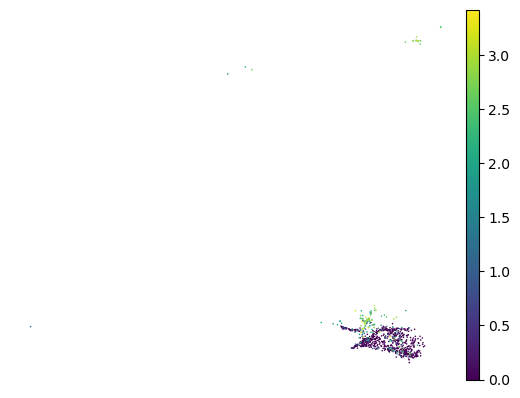

In [5]:
adata_12_0 = adata[adata.obs.subcluster == "12-0"].copy() 
sc.pl.umap(adata_12_0, color = "KRT19", legend_loc = "on data", frameon = False, title = "", size = 5)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


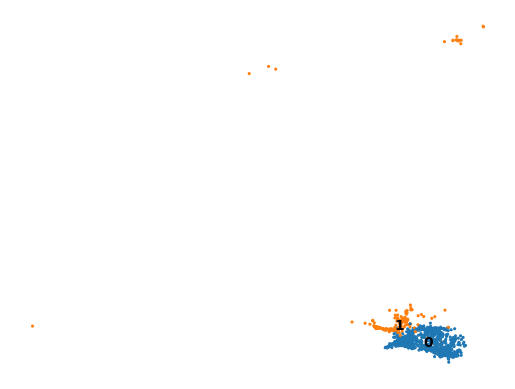

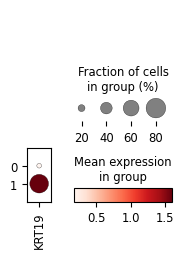

In [6]:
sc.tl.leiden(adata_12_0, key_added = "subcluster2", resolution = 0.1)
sc.pl.umap(adata_12_0, color = "subcluster2", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False)
sc.pl.dotplot(adata_12_0, ["KRT19"], groupby = "subcluster2");

In [7]:
cells_to_remove = adata_12_0[adata_12_0.obs.subcluster2 == "1"].obs.index
adata = adata[~adata.obs.index.isin(cells_to_remove)].copy()
adata

AnnData object with n_obs × n_vars = 71060 × 1000
    obs: 'Study_ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'subcluster'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SC ID_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

## Resolve deuterosomal cells

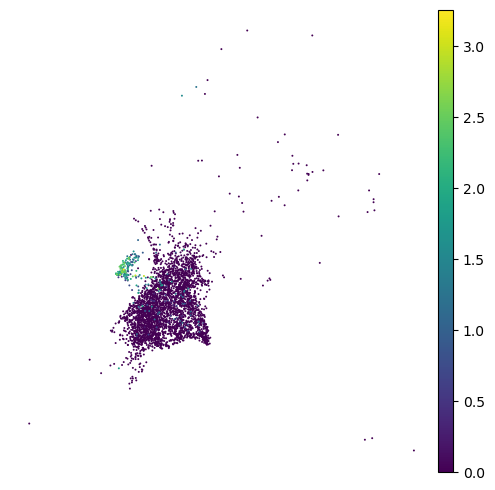

In [8]:
adata_sub = adata[adata.obs.subcluster == '9'].copy()

mpl.rcParams["figure.figsize"] = (6, 6)
sc.pl.umap(adata_sub, color = "CDC20B", legend_loc = "on data", frameon = False, title = "", size = 8)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


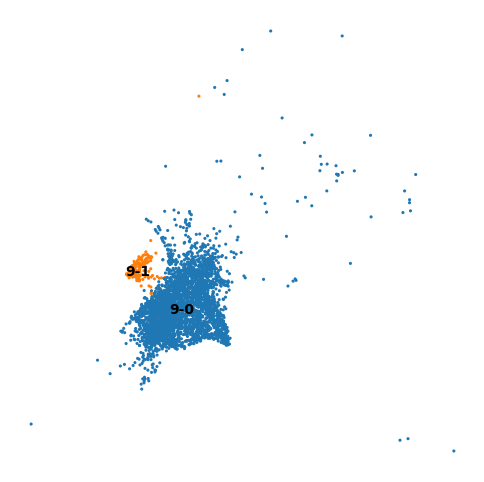

In [9]:
sc.tl.leiden(adata_sub, key_added = "subcluster2", resolution = 0.1)
cats = adata_sub.obs["subcluster2"].cat
adata_sub.obs["subcluster2"] = cats.rename_categories({c: '9-' + c for c in cats.categories})
sc.pl.umap(adata_sub, color = "subcluster2", legend_loc = "on data", frameon = False, title = "",
           size = 20, show = False);

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


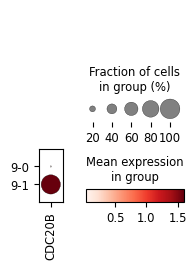

In [10]:
sc.pl.dotplot(adata_sub, ["CDC20B"], groupby = "subcluster2")

In [11]:
adata.obs.subcluster = adata.obs.subcluster.cat.add_categories(['9-0', '9-1'])
adata.obs.loc[adata_sub[adata_sub.obs.subcluster2 == "9-0"].obs.index, "subcluster"] = "9-0"
adata.obs.loc[adata_sub[adata_sub.obs.subcluster2 == "9-1"].obs.index, "subcluster"] = "9-1"
adata.obs.subcluster = adata.obs.subcluster.cat.remove_unused_categories()

## Add cell types

In [12]:
annotations = {
       '0': "Secretory cells",
       '1': "Squamous cells",
       '2': "Ciliated cells",
       '3': "Suprabasal cells",
       '4': "Suprabasal cells",
       '5': "Basal cells",
       '6': "Suprabasal cells",
       '7': "Suprabasal cells",
     '8-0': "Proliferating basal cells",
     '8-1': "MMP9 basal cells",
     '9-0': "Secretory ciliated cells",
     '9-1': "Deuterosomal cells",
      '10': "Squamous cells",
    '11-0': "CD8 T cells",
    '11-1': "CD4 T cells",
    '11-3': "gdT cells",
    '12-0': "Macrophages",
    '12-1': "DC2",
    '12-2': "Monocytes",
      '13': "Suprabasal cells",
      '14': "Mucous cells",
      '15': "Ciliated cells",
    '16-0': "pDC",
    '16-1': "B cells",
      '17': "Squamous cells",
      '18': "Erythrocytes",
      '19': "Ionocytes",
      '20': "Mast cells",
      '21': "Fibroblasts" 
}
adata.obs["cell_type"] = adata.obs["subcluster"].map(annotations).astype('category')

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


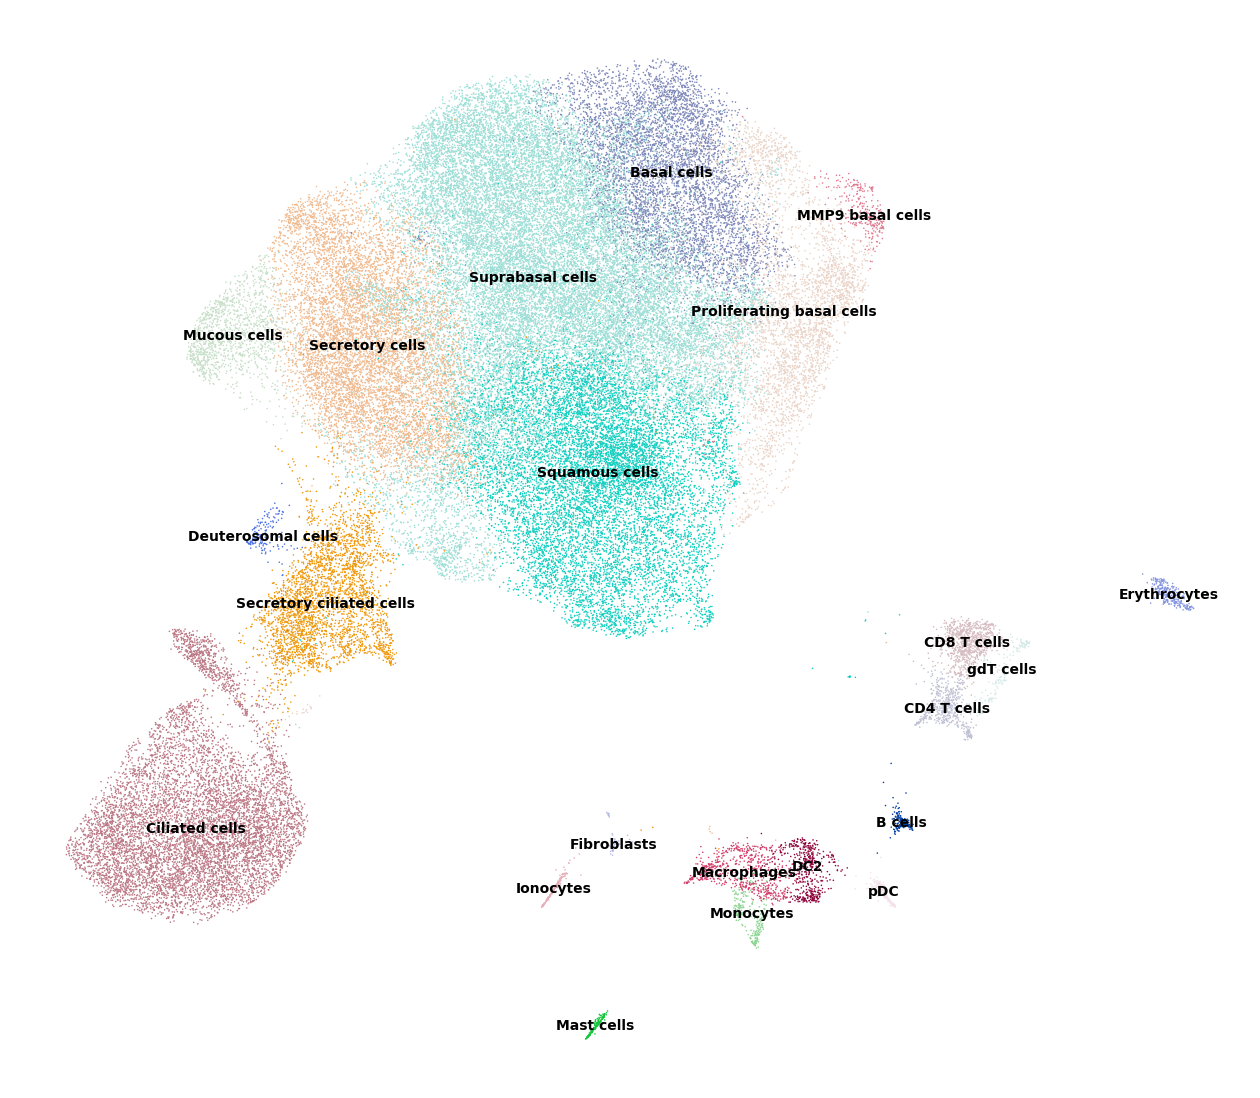

In [14]:
mpl.rcParams["figure.figsize"] = (16, 14)
sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", frameon = False, title = "", size = 5)

## Clean up metadata

In [15]:
adata.obs.columns

Index(['Study_ID', 'is_PASC', 'SC ID', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'n_genes', '_scvi_batch',
       '_scvi_labels', 'leiden_scVI', 'subcluster', 'cell_type'],
      dtype='object')

In [16]:
adata.obs = adata.obs.drop(columns = ['leiden_scVI'])
adata.obs = adata.obs.rename(columns = {'subcluster': 'cluster'})

In [ ]:
clust_dict = [{adata.obs.cluster.cat.categories[i]: str(i)} for i in range(len(np.unique(adata.obs.cluster)))]
clust_dict = {k: v for d in clust_dict for k, v in d.items()}
adata.obs.cluster = adata.obs.cluster.map(clust_dict).astype('category')
adata.obs

## Recompute markers

In [20]:
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, "cell_type", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [21]:
markers = sc_utils.get_markers(adata, "cell_type")
pd.options.display.max_rows = 200
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(5))

p_val  avg_logFC     pct.1     pct.2  \
cluster                                                                        
B cells                   12     6.520581e-71  14.333039  0.790960  0.000198   
                          136    8.037206e-07  13.085560  0.242938  0.000056   
                          141    3.194551e-06  12.866606  0.231638  0.000056   
                          30     1.810587e-58  12.367388  0.717514  0.000550   
                          152    4.117111e-05  10.940988  0.209040  0.000198   
Basal cells               215    0.000000e+00   3.339342  0.585535  0.108884   
                          204    0.000000e+00   3.152914  0.701843  0.153488   
                          206    0.000000e+00   2.944127  0.651599  0.172720   
                          205    0.000000e+00   2.889601  0.707928  0.189594   
                          346   1.067125e-184   2.879883  0.276426  0.047437   
CD4 T cells               598    1.524554e-08   8.928545  0.156673  0.000397   
                          455    3.995627e-82   7.445930  0.500967  0.005160   
                          457    3.827671e-79   7.047057  0.493230  0.007428   
                          423   3.650590e-139   7.009527  0.655706  0.009994   
                          592    2.128038e-09   6.900612  0.166344  0.002141   
CD8 T cells               600    0.000000e+00  10.622975  0.964109  0.006064   
                          691    2.399971e-59  10.069587  0.337871  0.000697   
                          640   4.253146e-147   9.279522  0.533416  0.001850   
                          627   1.123412e-183   9.114970  0.596535  0.002249   
                          732    8.367639e-30   8.717549  0.238861  0.000854   
Ciliated cells            801    0.000000e+00   5.997566  0.881075  0.060723   
                          804    0.000000e+00   5.833143  0.808232  0.048161   
                          811    0.000000e+00   5.704449  0.735989  0.040939   
                          813    0.000000e+00   5.671488  0.732149  0.039983   
                          808    0.000000e+00   5.643045  0.766471  0.045387   
DC2                       1118   9.200428e-51   9.169434  0.404564  0.001190   
                          1172   9.738924e-34   8.433299  0.329876  0.001530   
                          1000  3.384547e-300   8.094823  0.991701  0.075746   
                          1111   1.304009e-53   7.924454  0.417012  0.002281   
                          1083   1.522391e-75   7.891296  0.495851  0.003471   
Deuterosomal cells        1200   1.155986e-95  10.345545  0.974843  0.003216   
                          1314   1.992849e-12   6.928305  0.358491  0.004090   
                          1257   9.345481e-20   6.343009  0.452830  0.008110   
                          1273   1.620545e-16   6.213852  0.415094  0.006615   
                          1201   1.009294e-88   5.918980  0.955975  0.127149   
Erythrocytes              1400  2.388056e-174  15.127408  1.000000  0.061917   
                          1407   5.354114e-16  13.124155  0.297794  0.000099   
                          1424   4.705548e-02  12.811233  0.091912  0.000028   
                          1413   9.481872e-13  12.098470  0.264706  0.000198   
                          1401  7.329902e-121  11.876005  0.830882  0.002034   
Fibroblasts               1747   9.537470e-03  28.360615  0.253333  0.000000   
                          1606   9.111320e-33  15.769325  0.840000  0.000225   
                          1617   4.193763e-23  14.535973  0.706667  0.000141   
                          1655   9.719433e-09  13.969846  0.440000  0.000085   
                          1637   5.173991e-13  13.876036  0.533333  0.000070   
Ionocytes                 1806   4.007849e-64  11.709007  0.770588  0.000973   
                          1819   4.873637e-46  11.623706  0.652941  0.000522   
                          1855   6.634409e-21  11.621552  0.441176  0.000324   
                          1841   1.53755

## Save output

In [22]:
out_dir = "01NEP/01integrated_NEP_v2"
out_name = "01integrated_NEP_v2"

In [24]:
adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")